# PLEASE MAKE FOLDER CALLED, ./image/classification/1 until 5, to save the image resulted

1. Design a 3-layer feedforward neural network consisting of a hidden-layer of 10 neurons having logistic activation function and an output softmax layer. Assume a learning rate 𝛼 = 0.01 and decay parameter 𝛽 = 10−6. Use appropriate scaling of input features

In [151]:
import numpy as np
import theano
import theano.tensor as T
from common.time_executor import get_execution_time

# by specifying [10] as the hidden_layer_neuron implies using 1 hidden layer with 10 neurons
# respectively by specifying [100, 100] -> 2 hidden layers each layer 100 neurons


class SoftmaxNeuralNetwork:

    def __init__(self, train_x, train_y, num_features=6, list_of_neuron_on_hidden_layer=list([10]), decay=1e-6,
                 verbose=True):

        self.train_x = train_x
        self.train_y = train_y
        self.verbose = verbose

        self.num_train_data = len(train_x)

        self.train_cost = []
        self.train_prediction = []
        self.train_exec_time = []

        self.test_prediction = []

        weights = []
        biases = []

        # first layer which connect to the input layer
        weights.append(
            self.init_weight(len(train_x[0]), list_of_neuron_on_hidden_layer[0]))
        biases.append(
            self.init_bias(list_of_neuron_on_hidden_layer[0]))

        previous_layer = list_of_neuron_on_hidden_layer[0]

        for layer in range(1, len(list_of_neuron_on_hidden_layer)):
            weights.append(
                self.init_weight(previous_layer, list_of_neuron_on_hidden_layer[layer]))

            biases.append(
                self.init_bias(list_of_neuron_on_hidden_layer[layer]))
            previous_layer = list_of_neuron_on_hidden_layer[layer]

        # for output layer
        weights.append(
            self.init_weight(previous_layer, num_features)
        )

        biases.append(
            self.init_bias(num_features)
        )

        # construct neural network

        layers = []

        x_input = T.matrix('X')
        y_output = T.matrix('Y')

        prev_input = x_input

        for i in range(len(weights)-1):
            calculation = T.nnet.sigmoid(T.dot(prev_input, weights[i]) + biases[i])
            layers.append(calculation)
            prev_input = calculation

        # last output layer, use softmax function
        calculation = T.nnet.softmax(T.dot(prev_input, weights[len(weights)-1]) +
                                     biases[len(biases) - 1])
        layers.append(calculation)

        y_prediction = T.argmax(calculation, axis=1)

        sum_sqr_weights = T.sqr(weights[0])

        for i in range(1, len(weights)):
            sum_sqr_weights += T.sum(T.sqr(weights[i]))

        cost = T.mean(T.nnet.categorical_crossentropy(calculation, y_output)) + decay*T.sum(sum_sqr_weights)
        params = list(weights+biases)
        updates = self.sgd(cost=cost, params=params)

        self.computation = theano.function(
            inputs=[x_input, y_output],
            updates=updates,
            outputs=cost
        )

        self.prediction = theano.function(
            inputs=[x_input],
            outputs=y_prediction
        )

        return

    def init_bias(self, n):
        return theano.shared(np.zeros(n), theano.config.floatX)

    def init_weight(self, n_in, n_out, is_logistic_function=False):

        weight = np.random.uniform(
            size=(n_in, n_out),
            low=-np.sqrt(6. / (n_in + n_out)),
            high=np.sqrt(6. / (n_in + n_out)),
        )

        if is_logistic_function:
            weight = weight*4

        return theano.shared(weight, theano.config.floatX)

    def sgd(self, cost, params, lr=0.01):

        # return list of gradients
        grads = T.grad(cost=cost, wrt=params)

        updates = []
        for p, g in zip(params, grads):
            updates.append([p, p - g * lr])
        return updates

    def reshuffle_train_data(self):

        id_to_random = np.arange(self.num_train_data)
        np.random.shuffle(id_to_random)
        return self.train_x[id_to_random], self.train_y[id_to_random]

    def start_train(self, test_x, test_y, epochs=1000, batch_size=100):
        
        current_execution_time = 0
        
        for i in range(epochs):

            self.train_x, self.train_y = self.reshuffle_train_data()

            prediction_batch = []

            cost, exec_time = get_execution_time(self.start_one_iter_func, batch_size, prediction_batch)

            # predictions of train data
            prediction = np.mean(prediction_batch)
            
            self.train_cost.append(cost/(self.num_train_data/batch_size))
            self.train_prediction.append(prediction)
            
            current_execution_time += exec_time
            
            self.train_exec_time.append(current_execution_time)

            print_verbose = (i % 5*batch_size == 0 or i == epochs-1) and self.verbose

            self.start_test(test_x=test_x, test_y=test_y, print_verbose=print_verbose)

            if print_verbose:

                print ('execution_time: %s epoch: %d, train cost: %s, train predictions: %s \n' %
                       (np.sum(self.train_exec_time), i, cost, prediction))
                print('------------------------------------\n')

    def start_one_iter_func(self, batch_size, prediction_batch):

        cost = 0

        for cnt in range(0, len(self.train_x), batch_size):

            end = cnt + batch_size

            if end > len(self.train_x):
                end = len(self.train_x)

            train_x_batch, first_exec_time = get_execution_time(lambda: self.train_x[cnt:end])
            train_y_batch, second_exec_time = get_execution_time(lambda: self.train_y[cnt:end])

            # print ("first_exec_time: %d, second_exec_time: %s \n" % (first_exec_time, second_exec_time))

            cost += self.computation(train_x_batch, train_y_batch)
            # prediction = self.prediction(self.train_x)
            # predict_in_percentage = np.mean(np.argmax(self.train_y, axis=1) == prediction)
            # prediction_batch.append(predict_in_percentage)

        return cost

    def start_test(self, test_x, test_y, print_verbose):

        prediction = self.prediction(test_x)

        predict_in_percentage = np.mean(np.argmax(test_y, axis=1) == prediction)
        self.test_prediction.append(predict_in_percentage)

        if print_verbose:
            print ('test predictions: %s \n' % predict_in_percentage)

    def get_train_result(self):

        return self.train_cost, self.train_prediction, self.train_exec_time[len(self.train_exec_time)-1], self.train_exec_time

    def get_test_result(self):

        return self.test_prediction


Above code is the class to instanstiate the softmax neural network, Below is the implementation of data preprocessing

In [152]:
import pandas as pd
import numpy as np


class DataCollector:

    def __init__(self):
        self.df_train = pd.read_csv("./data/sat_train.txt", delimiter=' ')
        self.df_test = pd.read_csv("./data/sat_test.txt", delimiter=' ')

        # change the index
        self.df_train.columns = range(self.df_train.shape[1])
        self.df_test.columns = range(self.df_test.shape[1])

        self.x_train = self.df_train[range(36)]
        self.y_train = self.df_train[36]

        self.x_test = self.df_test[range(36)]
        self.y_test = self.df_test[36]

        self.x_min_train = self.x_train.min()
        self.x_max_train = self.x_train.max()

        self.x_min_test = self.x_test.min()
        self.x_max_test = self.x_test.max()

        return

    def get_train_data(self):

        return self.normalize_data(self.x_max_train, self.x_min_train, self.x_train), \
               self.one_hot_encoding_data(self.y_train)

    def get_test_data(self):

        return self.normalize_data(self.x_max_test, self.x_min_test, self.x_test),\
               self.one_hot_encoding_data(self.y_test)

    def one_hot_encoding_data(self, df, limit_number=6):

        # in this case data 6 is missing so, 7 we assume to be 6
        df[df == 7] = 6
        df_return = np.zeros((df.shape[0], limit_number))
        df_return[np.arange(df.shape[0]), df - 1] = 1
        return df_return

    def normalize_data(self, max_value, min_value, value):
        return (value - min_value)/(max_value-min_value)


As there is a need to calculate the execution time of giv
en function, hence, helper function to calculate the execution time is developed

In [153]:
import timeit


def get_execution_time(func, *args):
    start_time = timeit.default_timer()
    result = func(*args)
    elapsed = timeit.default_timer() - start_time
    return result, elapsed

Start training the simple multi layer softmax neural network

In [154]:
data_collector = DataCollector()
train_x, train_y = data_collector.get_train_data()
test_x, test_y = data_collector.get_test_data()

batch_size = 32
epochs = 1000

softmax_nn = SoftmaxNeuralNetwork(train_x=train_x.as_matrix(), train_y=train_y, list_of_neuron_on_hidden_layer=[10])
softmax_nn.start_train(batch_size=batch_size, test_x=test_x, test_y=test_y, epochs=epochs)


test predictions: 0.235117558779 

execution_time: 0.0130372047424 epoch: 0, train cost: 248.481490044, train predictions: nan 

------------------------------------

test predictions: 0.55927963982 

execution_time: 0.276296377182 epoch: 5, train cost: 227.190552905, train predictions: nan 

------------------------------------

test predictions: 0.625812906453 

execution_time: 0.898383617401 epoch: 10, train cost: 217.159782872, train predictions: nan 

------------------------------------

test predictions: 0.708354177089 

execution_time: 1.88490772247 epoch: 15, train cost: 205.669104695, train predictions: nan 

------------------------------------

test predictions: 0.722861430715 

execution_time: 3.21661615372 epoch: 20, train cost: 193.217133445, train predictions: nan 

------------------------------------

test predictions: 0.723861930965 

execution_time: 4.89169383049 epoch: 25, train cost: 180.587136405, train predictions: nan 

------------------------------------

tes

test predictions: 0.802901450725 

execution_time: 474.137586355 epoch: 255, train cost: 68.1882317636, train predictions: nan 

------------------------------------

test predictions: 0.802901450725 

execution_time: 492.774139643 epoch: 260, train cost: 67.9125360554, train predictions: nan 

------------------------------------

test predictions: 0.802901450725 

execution_time: 511.762405396 epoch: 265, train cost: 67.8307109537, train predictions: nan 

------------------------------------

test predictions: 0.8024012006 

execution_time: 531.099847555 epoch: 270, train cost: 67.639761187, train predictions: nan 

------------------------------------

test predictions: 0.8024012006 

execution_time: 550.789941549 epoch: 275, train cost: 67.4997726739, train predictions: nan 

------------------------------------

test predictions: 0.80340170085 

execution_time: 570.839922667 epoch: 280, train cost: 67.4262297479, train predictions: nan 

------------------------------------

test

test predictions: 0.810905452726 

execution_time: 1879.56844068 epoch: 510, train cost: 63.9158102895, train predictions: nan 

------------------------------------

test predictions: 0.811405702851 

execution_time: 1916.32301283 epoch: 515, train cost: 63.9845778558, train predictions: nan 

------------------------------------

test predictions: 0.810405202601 

execution_time: 1953.42754197 epoch: 520, train cost: 63.719460139, train predictions: nan 

------------------------------------

test predictions: 0.811405702851 

execution_time: 1990.89064789 epoch: 525, train cost: 63.9839486941, train predictions: nan 

------------------------------------

test predictions: 0.810405202601 

execution_time: 2028.73139048 epoch: 530, train cost: 63.8048719194, train predictions: nan 

------------------------------------

test predictions: 0.811405702851 

execution_time: 2066.95775008 epoch: 535, train cost: 63.7577591904, train predictions: nan 

------------------------------------


test predictions: 0.815907953977 

execution_time: 4210.40768027 epoch: 765, train cost: 61.9773233434, train predictions: nan 

------------------------------------

test predictions: 0.817908954477 

execution_time: 4265.37770653 epoch: 770, train cost: 61.8719924822, train predictions: nan 

------------------------------------

test predictions: 0.817408704352 

execution_time: 4320.69378757 epoch: 775, train cost: 61.9267031864, train predictions: nan 

------------------------------------

test predictions: 0.815907953977 

execution_time: 4376.34420896 epoch: 780, train cost: 61.9297872425, train predictions: nan 

------------------------------------

test predictions: 0.817408704352 

execution_time: 4432.34332728 epoch: 785, train cost: 62.0289935859, train predictions: nan 

------------------------------------

test predictions: 0.816408204102 

execution_time: 4488.68117499 epoch: 790, train cost: 61.8372321203, train predictions: nan 

------------------------------------

2.Find the optimal batch size for mini-batch gradient descent while training the neural network by evaluating the performances for different batch sizes. Set this as the batch size for the rest of the experiments

a) Plot the training error and test accuracy against number of epochs for the 3-layer
network for each batch size. Limit search space to:{4,8,16,32,64}. 

As the helper class to do plotting stuff, we create another class to do such task.

In [155]:
import matplotlib.pyplot as plt


class DataVisualization:

    def __init__(self):
        return

    def show_plot(self, list_x_point, list_y_point, x_label, y_label, title, figure_name, labels):
        plt.figure()
        plt.plot(list_x_point, list_y_point)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        plt.legend()
        plt.savefig(figure_name)
        plt.show()

a.Plot the training error and test accuracy against number of epochs for the 3-layer
network for each batch size. Limit search space to:{4,8,16,32,64}. 

train with batch size 4, 8, 16, 32 ,64

execution_time: 80.7212705612 
execution_time: 40.9477365017 
execution_time: 23.528857708 
execution_time: 13.7505939007 
execution_time: 8.24612522125 


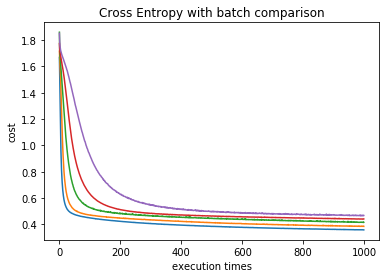

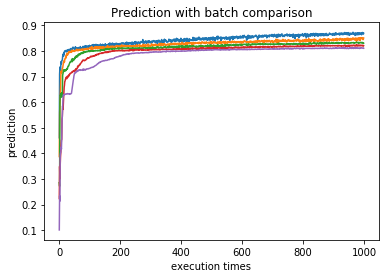

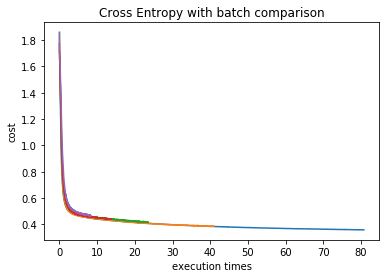

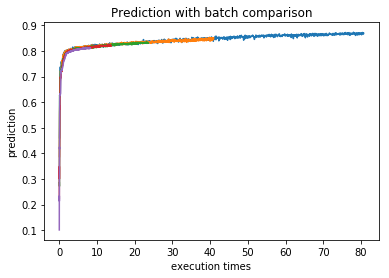

In [156]:
data_collector = DataCollector()
train_x, train_y = data_collector.get_train_data()
test_x, test_y = data_collector.get_test_data()

# number_data = train_x.shape[0]
list_batch = [4, 8, 16, 32, 64]
list_execution_time = []

epochs = 1000

costs = []
predictions = []
list_exec_times = []

for i in range(epochs):
    costs.append([])
    predictions.append([])
    list_exec_times.append([])

for batch in list_batch:
    
    softmax_nn = SoftmaxNeuralNetwork(train_x=train_x.as_matrix(), train_y=train_y, 
                                      list_of_neuron_on_hidden_layer=[10], verbose=False)
    softmax_nn.start_train(batch_size=batch, test_x=test_x, test_y=test_y, epochs=epochs)

    cost_train, prediction_train, exec_time, list_exec_time = softmax_nn.get_train_result()
    prediction_test = softmax_nn.get_test_result()
    
    cnt = 0
    
    for indiv_cost in cost_train: 
        costs[cnt].append(indiv_cost)
        cnt += 1
    
    cnt = 0
    
    for indiv_prediction in prediction_test: 
        predictions[cnt].append(indiv_prediction)
        cnt += 1
    
    cnt = 0
    
    for indiv_time in list_exec_time: 
        list_exec_times[cnt].append(indiv_time)
        cnt += 1
    
    list_execution_time.append(exec_time)
    
    print "execution_time: %s " % exec_time
    
%matplotlib inline

data_visualization.show_plot(
    list_x_point=range(epochs), list_y_point=costs,
    x_label="execution times", y_label="cost",
    title="Cross Entropy with batch comparison",
    figure_name="./image/classification/2/"+str(batch)+"_cross_entropy.png",
    labels=[]
)

data_visualization.show_plot(
    list_x_point=range(epochs), list_y_point=predictions,
    x_label="execution times", 
    y_label="prediction", 
    title="Prediction with batch comparison", 
    figure_name="./image/classification/2/"+str(batch)+"_prediction.png",
    labels=[]
)

data_visualization.show_plot(
    list_x_point=list_exec_times, list_y_point=costs,
    x_label="execution times", y_label="cost",
    title="Cross Entropy with batch comparison",
    figure_name="./image/classification/2/"+str(batch)+"_cross_entropy.png",
    labels=[]
)

data_visualization.show_plot(
    list_x_point=list_exec_times, list_y_point=predictions,
    x_label="execution times", 
    y_label="prediction", 
    title="Prediction with batch comparison", 
    figure_name="./image/classification/2/"+str(batch)+"_prediction.png",
    labels=[]
)

b) Plot the time taken to update parameters of the network for different batch sizes.

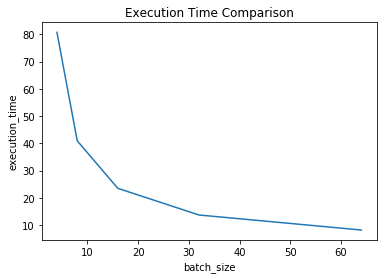

In [157]:
%matplotlib inline

data_visualization.show_plot(
    list_x_point=list_batch, list_y_point=list_execution_time,
    x_label="batch_size", y_label="execution_time", title="Execution Time Comparison", 
    figure_name="./image/classification/2/execution_time_comparison.png",
    labels=[]
)

c) State the rationale for selecting the optimal batch size.

16 batch size, since it give a decent result with decent execution time

3. Find the optimal number of hidden neurons for the 3-layer network designed in part (2). Set this number of neurons in hidden layer for the rest of the experiments.

a) Plot the training error and test accuracy against number of epochs for the 3-layer
network at hidden-layer neurons. Limit the search space to the set:
{5,10,15,20,25}.

execution_time: 21.6235640049 
execution_time: 22.9873020649 
execution_time: 23.6048748493 
execution_time: 24.3123316765 
execution_time: 26.141541481 


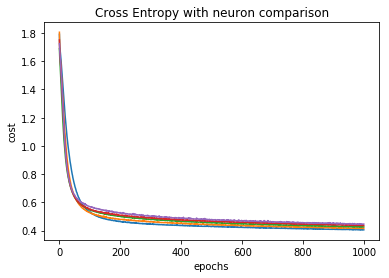

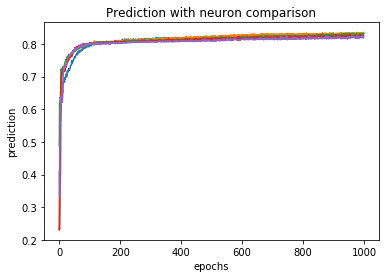

In [164]:
# visualize
data_visualization = DataVisualization()

list_neurons = [5, 10, 15, 20, 25]
batch_size = 16
epochs = 1000

costs = []
predictions = []
list_exec_times = []

list_execution_time = []

for i in range(epochs):
    costs.append([])
    predictions.append([])
    list_exec_times.append([])

for neurons in list_neurons:

    softmax_nn = SoftmaxNeuralNetwork(train_x=train_x.as_matrix(), train_y=train_y, 
                                      list_of_neuron_on_hidden_layer=[neurons], verbose=False)
    softmax_nn.start_train(batch_size=batch_size, test_x=test_x, test_y=test_y, epochs=epochs)
    
    cost_train, prediction_train, exec_time, list_exec_time = softmax_nn.get_train_result()
    prediction_test = softmax_nn.get_test_result()
    
    cnt = 0
    
    for indiv_cost in cost_train: 
        costs[cnt].append(indiv_cost)
        cnt += 1
    
    cnt = 0
    
    for indiv_prediction in prediction_test: 
        predictions[cnt].append(indiv_prediction)
        cnt += 1
    
    cnt = 0
    
    for indiv_time in list_exec_time: 
        list_exec_times[cnt].append(indiv_time)
        cnt += 1
    
    list_execution_time.append(exec_time)
    
    print "execution_time: %s " % exec_time

%matplotlib inline

data_visualization.show_plot(
    list_x_point=range(epochs), list_y_point=costs,
    x_label="epochs", y_label="cost", 
    title="Cross Entropy with neuron comparison", 
    figure_name="./image/classification/2/"+str(batch)+"_cross_entropy.png",
    labels=list_neurons
)

data_visualization.show_plot(
    list_x_point=range(epochs), list_y_point=predictions,
    x_label="epochs", y_label="prediction", 
    title="Prediction with neuron comparison", 
    figure_name="./image/classification/2/"+str(batch)+"_prediction.png",
    labels=list_neurons
)

b) Plot the time to update parameters of the network for different number of hiddenlayer
neurons

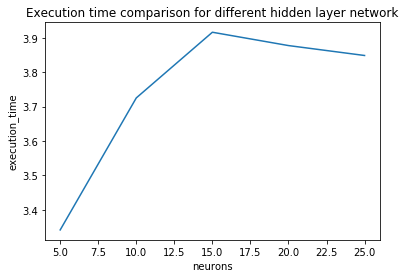

In [163]:
%matplotlib inline

data_visualization.show_plot(
    list_x_point=list_neurons, list_y_point=list_execution_time,
    x_label="neurons", y_label="execution_time", title="Execution time comparison for different hidden layer network",
    figure_name="./image/classification/3/hidden_layer_xec_time_comparison.png", labels=[]
)

c) State the rationale for selecting the optimal number of hidden neurons

15 number of neurons, since 5,10 neurons lead low accuracy during 30 epochs, but the rest of neurons perform quite same, so we choose the less complex neural structure.

4. Find optimal decay parameter for the 3-layer network designed in part (3)

a) Plot the training error against number of epochs for the 3-layer network for
different values of decay parameter in search space{0, 10−3
,10−6
, 10−9
,10−12}.
b) Plot the test accuracy against the different values of decay parameter.

decay: 0.1 

decay: 0.01 

decay: 0.001 

decay: 0.0001 



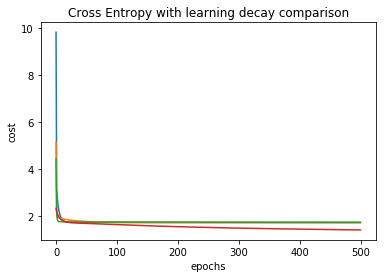

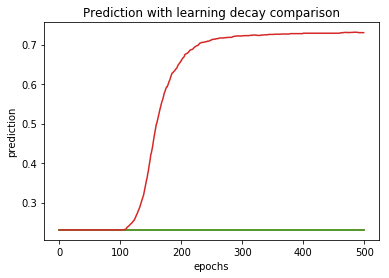

In [117]:
data_visualization = DataVisualization()

learning_decays = [1e-1,1e-2, 1e-3, 1e-4]
batch_size = 64
epochs = 500

costs = []
predictions = []
list_exec_times = []
list_execution_time = []

for i in range(epochs):
    costs.append([])
    predictions.append([])
    list_exec_times.append([])

for decay in learning_decays:
    print "decay: %s \n" % decay
    softmax_nn = SoftmaxNeuralNetwork(train_x=train_x.as_matrix(), train_y=train_y, 
                                      list_of_neuron_on_hidden_layer=[1], 
                                      verbose=False, decay=decay)
    softmax_nn.start_train(batch_size=batch_size, test_x=test_x, 
                           test_y=test_y, epochs=epochs)
    
    cost_train, prediction_train, exec_time, list_exec_time = softmax_nn.get_train_result()
    prediction_test = softmax_nn.get_test_result() 
    list_training_error.append(cost_train)
    list_test_prediction.append(prediction_test)
    
    cnt = 0
    
    for indiv_cost in cost_train: 
        costs[cnt].append(indiv_cost)
        cnt += 1
    
    cnt = 0
    
    for indiv_prediction in prediction_test: 
        predictions[cnt].append(indiv_prediction)
        cnt += 1
    
    cnt = 0
    
    for indiv_time in list_exec_time: 
        list_exec_times[cnt].append(indiv_time)
        cnt += 1
    
    list_execution_time.append(exec_time)
    
%matplotlib inline
    
data_visualization.show_plot(
    list_x_point=range(epochs), list_y_point=costs,
    x_label="epochs", y_label="cost", 
    title="Cross Entropy with learning decay comparison", 
    figure_name="./image/classification/2/"+str(batch)+"_cross_entropy.png",
    labels=list_neurons
)

data_visualization.show_plot(
    list_x_point=range(epochs), list_y_point=predictions,
    x_label="epochs", y_label="prediction", 
    title="Prediction with learning decay comparison", 
    figure_name="./image/classification/2/"+str(batch)+"_prediction.png",
    labels=list_neurons
)


c) State the rationale for selecting the optimal decay parameter. 

Learing decay causing the cost function to be adjusted based on the weight, which means more fluctuation happened, such that the best learning decay is the one which give us the less fluctuate result.

5. After you’re done with the 3-layer network, design a 4-layer network with two hiddenlayers,each consisting of 10 neurons with logistic activation functions, batch size of 32 and decay parameter 10-6.

a) Plot the train and test accuracy of the 4-layer network.
b) Compare and comment on the performances on 3-layer and 4-layer networks.

test predictions: 0.230615307654 

execution_time: 0.0322439670563 epoch: 0, train cost: 474.083356311, train predictions: nan 

------------------------------------

test predictions: 0.230615307654 

execution_time: 0.669607639313 epoch: 5, train cost: 466.728422888, train predictions: nan 

------------------------------------

test predictions: 0.230615307654 

execution_time: 2.07092285156 epoch: 10, train cost: 461.399275078, train predictions: nan 

------------------------------------

test predictions: 0.230615307654 

execution_time: 4.27770614624 epoch: 15, train cost: 452.82787209, train predictions: nan 

------------------------------------

test predictions: 0.230615307654 

execution_time: 7.31334781647 epoch: 20, train cost: 437.559711251, train predictions: nan 

------------------------------------

test predictions: 0.230615307654 

execution_time: 11.1590030193 epoch: 25, train cost: 412.414836801, train predictions: nan 

------------------------------------

test

test predictions: 0.79739869935 

execution_time: 1017.1070137 epoch: 250, train cost: 143.321480071, train predictions: nan 

------------------------------------

test predictions: 0.797898949475 

execution_time: 1057.85602164 epoch: 255, train cost: 143.071496013, train predictions: nan 

------------------------------------

test predictions: 0.798899449725 

execution_time: 1099.41248584 epoch: 260, train cost: 142.828115274, train predictions: nan 

------------------------------------

test predictions: 0.798899449725 

execution_time: 1141.77894974 epoch: 265, train cost: 142.590902134, train predictions: nan 

------------------------------------

test predictions: 0.799899949975 

execution_time: 1184.96218395 epoch: 270, train cost: 142.359465045, train predictions: nan 

------------------------------------

test predictions: 0.80140070035 

execution_time: 1228.98188782 epoch: 275, train cost: 142.133450789, train predictions: nan 

------------------------------------

t

test predictions: 0.815907953977 

execution_time: 4036.23535085 epoch: 500, train cost: 134.892010439, train predictions: nan 

------------------------------------

test predictions: 0.816408204102 

execution_time: 4117.11352539 epoch: 505, train cost: 134.766349642, train predictions: nan 

------------------------------------

test predictions: 0.816908454227 

execution_time: 4198.8143239 epoch: 510, train cost: 134.641602265, train predictions: nan 

------------------------------------

test predictions: 0.817908954477 

execution_time: 4281.34036303 epoch: 515, train cost: 134.517756117, train predictions: nan 

------------------------------------

test predictions: 0.817908954477 

execution_time: 4364.73311138 epoch: 520, train cost: 134.39480039, train predictions: nan 

------------------------------------

test predictions: 0.817908954477 

execution_time: 4448.9913435 epoch: 525, train cost: 134.272725551, train predictions: nan 

------------------------------------

t

test predictions: 0.825412706353 

execution_time: 9041.18303084 epoch: 750, train cost: 129.621910823, train predictions: nan 

------------------------------------

test predictions: 0.825412706353 

execution_time: 9160.71363878 epoch: 755, train cost: 129.535800776, train predictions: nan 

------------------------------------

test predictions: 0.825912956478 

execution_time: 9280.99426055 epoch: 760, train cost: 129.450353718, train predictions: nan 

------------------------------------

test predictions: 0.826413206603 

execution_time: 9402.03292084 epoch: 765, train cost: 129.365562772, train predictions: nan 

------------------------------------

test predictions: 0.826413206603 

execution_time: 9523.81012702 epoch: 770, train cost: 129.281420994, train predictions: nan 

------------------------------------

test predictions: 0.826413206603 

execution_time: 9646.32557964 epoch: 775, train cost: 129.19792138, train predictions: nan 

------------------------------------


test predictions: 0.833916958479 

execution_time: 15904.3226988 epoch: 999, train cost: 126.002648732, train predictions: nan 

------------------------------------

test predictions: 0.230615307654 

execution_time: 0.0241279602051 epoch: 0, train cost: 466.438807028, train predictions: nan 

------------------------------------

test predictions: 0.230615307654 

execution_time: 0.501682281494 epoch: 5, train cost: 418.80856294, train predictions: nan 

------------------------------------

test predictions: 0.277138569285 

execution_time: 1.59096384048 epoch: 10, train cost: 367.037038816, train predictions: nan 

------------------------------------

test predictions: 0.617308654327 

execution_time: 3.29579091072 epoch: 15, train cost: 320.954406191, train predictions: nan 

------------------------------------

test predictions: 0.701850925463 

execution_time: 5.63536477089 epoch: 20, train cost: 282.047933263, train predictions: nan 

------------------------------------

tes

test predictions: 0.810905452726 

execution_time: 773.531196833 epoch: 250, train cost: 129.651005481, train predictions: nan 

------------------------------------

test predictions: 0.810905452726 

execution_time: 804.54971242 epoch: 255, train cost: 129.439232886, train predictions: nan 

------------------------------------

test predictions: 0.810905452726 

execution_time: 836.160122156 epoch: 260, train cost: 129.232532977, train predictions: nan 

------------------------------------

test predictions: 0.810905452726 

execution_time: 868.364586115 epoch: 265, train cost: 129.030583317, train predictions: nan 

------------------------------------

test predictions: 0.811405702851 

execution_time: 901.16854167 epoch: 270, train cost: 128.833091609, train predictions: nan 

------------------------------------

test predictions: 0.811905952976 

execution_time: 934.587581396 epoch: 275, train cost: 128.639792357, train predictions: nan 

------------------------------------



test predictions: 0.822411205603 

execution_time: 3070.51290536 epoch: 500, train cost: 122.31371708, train predictions: nan 

------------------------------------

test predictions: 0.822411205603 

execution_time: 3131.95748186 epoch: 505, train cost: 122.205331451, train predictions: nan 

------------------------------------

test predictions: 0.821410705353 

execution_time: 3194.00064087 epoch: 510, train cost: 122.097898496, train predictions: nan 

------------------------------------

test predictions: 0.821410705353 

execution_time: 3256.65455985 epoch: 515, train cost: 121.991402073, train predictions: nan 

------------------------------------

test predictions: 0.821910955478 

execution_time: 3319.92769003 epoch: 520, train cost: 121.885826488, train predictions: nan 

------------------------------------

test predictions: 0.821910955478 

execution_time: 3383.82718349 epoch: 525, train cost: 121.781156473, train predictions: nan 

------------------------------------


test predictions: 0.827913956978 

execution_time: 6893.41198397 epoch: 750, train cost: 117.816006867, train predictions: nan 

------------------------------------

test predictions: 0.828914457229 

execution_time: 6985.56036758 epoch: 755, train cost: 117.741070033, train predictions: nan 

------------------------------------

test predictions: 0.828914457229 

execution_time: 7078.30481505 epoch: 760, train cost: 117.666590257, train predictions: nan 

------------------------------------

test predictions: 0.829414707354 

execution_time: 7171.6486547 epoch: 765, train cost: 117.592561842, train predictions: nan 

------------------------------------

test predictions: 0.829414707354 

execution_time: 7265.59657407 epoch: 770, train cost: 117.518979218, train predictions: nan 

------------------------------------

test predictions: 0.829914957479 

execution_time: 7360.15290475 epoch: 775, train cost: 117.445836938, train predictions: nan 

------------------------------------


test predictions: 0.833416708354 

execution_time: 12223.6298513 epoch: 999, train cost: 114.554338642, train predictions: nan 

------------------------------------



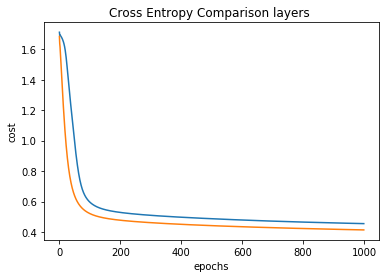

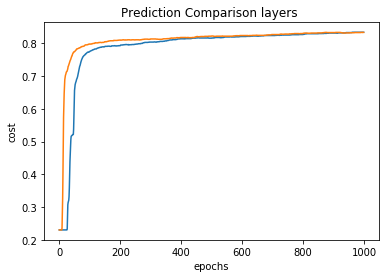

In [136]:
number_data=16
epochs=1000

costs = []
predictions = []


for i in range(epochs):
    costs.append([])
    predictions.append([])

softmax_nn = SoftmaxNeuralNetwork(train_x=train_x.as_matrix(), train_y=train_y, list_of_neuron_on_hidden_layer=[10, 10])
softmax_nn.start_train(batch_size=number_data, test_x=test_x, test_y=test_y, epochs=epochs)

cost_train_4_layer, _, _, _ = softmax_nn.get_train_result()
prediction_test_4_layer = softmax_nn.get_test_result()

cnt = 0

for indiv_cost in cost_train_4_layer: 
    costs[cnt].append(indiv_cost)
    cnt += 1

cnt = 0

for indiv_prediction in prediction_test_4_layer: 
    predictions[cnt].append(indiv_prediction)
    cnt += 1


softmax_nn = SoftmaxNeuralNetwork(train_x=train_x.as_matrix(), train_y=train_y, list_of_neuron_on_hidden_layer=[10])
softmax_nn.start_train(batch_size=number_data, test_x=test_x, test_y=test_y, epochs=epochs)

cost_train_3_layer, _, _, _ = softmax_nn.get_train_result()
prediction_test_3_layer = softmax_nn.get_test_result()

cnt = 0

for indiv_cost in cost_train_3_layer: 
    costs[cnt].append(indiv_cost)
    cnt += 1

cnt = 0

for indiv_prediction in prediction_test_3_layer: 
    predictions[cnt].append(indiv_prediction)
    cnt += 1



data_visualization.show_plot(
    list_x_point=range(epochs), list_y_point=costs,
    x_label="epochs", y_label="cost", title="Cross Entropy Comparison layers ",
    figure_name="./image/classification/5/4_layer_cross_entropy.png",
    labels=[]
)

data_visualization.show_plot(
    list_x_point=range(epochs), list_y_point=predictions,
    x_label="epochs", y_label="cost", title="Prediction Comparison layers ",
    figure_name="./image/classification/5/4_layer_prediction.png",
    labels=[]
)


b) Compare and comment on the performances on 3-layer and 4-layer networks.

the performance of 3 layer with 4 layer is quite similar therefore we choose 3 layer neurons since it gives similar performance with less complex model

The best neural network structure is with 3 hidden layer, since it is less complex and give the same result with the 4 hidden layer model.